**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***

# Part II: Agents

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebooks**: [guides/router_agents_guide.ipynb](guides/agents_guide.ipynb) and [guides/tool_agents_guide.ipynb](guides/tool_agents_guide.ipynb)


***
<br>

* Play around with the agent systems in the guides. Maybe try to create a similar system with new nodes? Or you can try to add new tools to the existing tool-using agent system.

* Remember to include some reflections on your results. Are there, for example, any hyperparameters that are particularly important?

* You should follow the steps given in the `router_agents_guide` notebook or the `tool_agents_guide` notebook to create your own agent system - or try to optimize the existing ones.

<br>

***

## what to  do

 Part 2: AI Agents
In this part, you will implement and evaluate a simple tool-using LLM Agent using LangGraph (or any other framework you want!). Specifically, your task is to:

- Explore the accompanying agents guides (`guides/router_agents_guide.ipynb` and `guides/tool_agents_guide.ipynb`).
- Use LangGraph to create a simple `router` agent *OR* tool-using LLM Agent in the `assignments/agents.ipynb` notebook.
- Experiment with different techniques covered in the course to (possibly) improve performance over the baseline in `router_agents.ipynb` or `tool_agents.ipynb`.
- Evaluate your AI Agent - or at least comment on how you would evaluate it.
- Briefly reflect on the performance of your system and your choices of preprocessing, hyperparameters etc.
    - Write your analysis as a markdown cell in the bottom of the notebook.


## IMPORTS

In [2]:
# built-in libraries
from typing import Literal, TypedDict,  Any, Optional

# langgraph libraries
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.graph import  MermaidDrawMethod

# misc libraries
from pydantic import Field
from IPython.display import Image
from decouple import config
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from tqdm import tqdm
from sklearn.metrics import f1_score

# local modules
from src.llm import LLMCaller, BaseResponse

ENV credentials

In [3]:
WX_API_KEY = config("WX_API_KEY")
WX_PROJECT_ID = config("WX_PROJECT_ID")
WX_API_URL = "https://us-south.ml.cloud.ibm.com"

Connection 

In [4]:
model = LLMCaller(
    api_key=WX_API_KEY,
    project_id=WX_PROJECT_ID,
    api_url=WX_API_URL,
    model_id= "watsonx/ibm/granite-3-8b-instruct",
    params={
        GenParams.TEMPERATURE: 0.0,
        GenParams.MAX_NEW_TOKENS: 50,
        GenParams.TOP_P: 0.45,
    }
)

testing connection

In [5]:
response = model.invoke(prompt="Write a haiku about a fish")

response

BaseResponse(answer="Sleek fish swims in blue,\nSilent whispers in the flow,\nNature's gentle hue.")

## simple email classification agent

In [87]:
class EmailState(TypedDict):

    email: dict[str, Any]  # The email being processed - Contains subject, sender, body, etc.
    email_category: Optional[str]  # Category of the email (e.g., work, personal, etc.
    spam_reason: Optional[str]  # Reason for categorizing the email as spam
    is_spam: Optional[bool]  # Whether the email is deemed to be spam or not
    draft: Optional[str]  # Draft response to the email
    verbose : bool = False  # Whether to provide verbose output

In [88]:
# Initialize our LLM
def read_email(state: EmailState):
    """Mailbot reads and logs the incoming email"""
    email = state["email"]  # Extract the email from the state
    
    if state["verbose"]:
        print(f"Mailbot is processing an email from {email['sender']} with subject: {email['subject']}")
    
    # No state changes needed here
    return {} # <- if we don't need to update the state, we return an empty dictionary

def classify_email(state: EmailState):
    """Mailbot uses an LLM to determine if the email is spam or legitimate"""
    email = state["email"]  # Extract the email from the state
    
    # Prepare our prompt for the LLM
    prompt = f"""Analyze this email and determine if it is spam or legitimate.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    First, determine if this email is spam, phishing attempt, scam or of other malicious intend. If it is explain why.
    If it is legitimate, categorize it into one of the categories (Transactional, Marketing, Relational, Administrative, Security/alert. thank you.)
    """
    
    # Create our response model
    response_model = model.create_response_model(
        "EmailAnalysis", 
        {
            "spam_reason": (str, Field(description="The reasoning behind the decision.")),
            "is_spam": (bool, Field(description="Whether the email is spam, phishing, scam or of other malicious intend.")),
            "email_category": (Literal["Transactional", "Marketing", "Relational", "Administrative", "Security/alert", "Spam"], Field(description="The category of the email.")) 
        }
    )

    # Call the LLMCaller with the prompt and response model
    response = model.invoke(prompt, response_model=response_model)

    # Extract the response data
    is_spam = response.is_spam
    spam_reason = response.spam_reason
    email_category = response.email_category
    
    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
    }

def handle_spam(state: EmailState):
    """Mailbot discards spam email with a note"""

    if state["verbose"]:
        print(f"Mailbot has identified the email as spam. Reason: {state['spam_reason']}")
        print("The email has been moved to the spam folder.")
    
    # We're done processing this email
    return {}

def draft_response(state: EmailState):
    """Mailbot drafts a preliminary response for legitimate emails"""
    email = state["email"]  # Extract the email from the state
    category = state["email_category"] or "general"  # Default to a general category if not specified
    
    # Prepare our prompt for the LLM
    prompt = f"""Draft a polite preliminary response to this email.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    Draft a brief, professional response that your employer can review and personalize before sending.
    """
    
    # Call the LLM - this time without a custom response model
    response = model.invoke(prompt) # we can use the default response model here
    answer = response.answer  # Extract the response from the LLM

    # Return state updates
    return {"draft": answer}  # add the draft response to the state


def notify(state: EmailState):
    """Mailbot notifies its employer about the email and presents the draft response"""
    email = state["email"]  # Extract the email from the state
    
    if state["verbose"]:
        # some pretty printing to emulate the notification
        print("\n" + "="*50)
        print(f"Hi boss, you've received an email from {email['sender']}.")
        print(f"Subject: {email['subject']}")
        print(f"Category: {state['email_category']}")
        print("\nI've prepared a draft response for your review:")
        print("-"*50)
        print(state["draft"])
        print("="*50 + "\n")
    
    # We're done processing this email
    return {}

Making the edge fucntions - what happens next


In [89]:
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]:  # If the email is spam
        return "spam"  # Route to the spam handling step
    else:
        return "legitimate"  # Route to legitimate email handling step

In [90]:
# DETAILED GRAPH
# Create the graph
email_graph = StateGraph(EmailState)  # Initialize with EmailState

# Add nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("draft_response", draft_response)
email_graph.add_node("notify", notify)

# Define edges
email_graph.add_edge(START, "read_email")  # Start with reading the email
email_graph.add_edge("read_email", "classify_email")  # After reading, classify

# Add conditional branching from classify_email
email_graph.add_conditional_edges(
    "classify_email",
    route_email,  # Routing function
    {
        "spam": "handle_spam",  # Route to spam handling
        "legitimate": "draft_response"  # Route to response drafting
    }
)

# Add final edges
email_graph.add_edge("handle_spam", END)  # End after handling spam
email_graph.add_edge("draft_response", "notify")  # Draft then notify
email_graph.add_edge("notify", END)  # End after notification

# Compile the graph
compiled_graph = email_graph.compile()

Visualise the flow

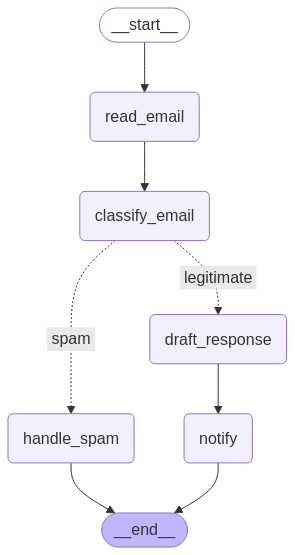

In [91]:
# Visualize the graph
Image(compiled_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API))

## testing the system

In [92]:
# Example legitimate email
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Valentino, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

In [93]:

# Process the legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke(
    {
        "email": legitimate_email, # invoke the graph with the email
        "verbose": True,  # enable verbose output
    }
)


Processing legitimate email...
Mailbot is processing an email from john.smith@example.com with subject: Question about your services

Hi boss, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: Relational

I've prepared a draft response for your review:
--------------------------------------------------
Dear John,

Thank you for reaching out and expressing interest in our services. I appreciate the referral from your colleague. I'd be more than happy to discuss our consulting services further. I'm available next week to schedule a call. Please let me know a few dates and times that work for you, and I'll arrange a call accordingly.

Best regards,
Valentino



In [94]:
legitimate_result

{'email': {'sender': 'john.smith@example.com',
  'subject': 'Question about your services',
  'body': "Dear Mr. Valentino, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"},
 'email_category': 'Relational',
 'spam_reason': 'The email is from a known contact, includes a personalized greeting, and the content is relevant to business consulting services. It does not contain any malicious links, requests for sensitive information, or suspicious language.',
 'is_spam': False,
 'draft': "Dear John,\n\nThank you for reaching out and expressing interest in our services. I appreciate the referral from your colleague. I'd be more than happy to discuss our consulting services further. I'm available next week to schedule a call. Please let me know a few dates and times that work for you, and I'll arrange a call accordingly.\n\nBest regards,\nValentino",
 'verbose': True}

## test process spam email


In [95]:

# Process the legitimate email
print("\nProcessing legitimate email...")
illegitimate_result = compiled_graph.invoke(
    {
        "email": spam_email, # invoke the graph with the email
        "verbose": True,  # enable verbose output
    }
)


Processing legitimate email...
Mailbot is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Mailbot has identified the email as spam. Reason: The email promises an unexpected, large sum of money for a small fee. It also requests sensitive personal information (bank details) from the recipient, which is a common tactic used in scams.
The email has been moved to the spam folder.


In [96]:
illegitimate_result

{'email': {'sender': 'winner@lottery-intl.com',
  'subject': 'YOU HAVE WON $5,000,000!!!',
  'body': 'CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100.'},
 'email_category': 'Marketing',
 'spam_reason': 'The email promises an unexpected, large sum of money for a small fee. It also requests sensitive personal information (bank details) from the recipient, which is a common tactic used in scams.',
 'is_spam': True,
 'verbose': True}

In [97]:
legitimate_emails = [
    {
        "sender": "sarah.johnson@acme-corp.com",
        "subject": "Meeting agenda for Thursday",
        "body": "Hi team, Attached is the agenda for our quarterly review meeting on Thursday at 2 PM. Please review the attached documents before we meet. Let me know if you have any questions. Best, Sarah",
        "is_spam": False,
        "category": "Administrative"
    },
    {
        "sender": "tech-support@cloudservices.net",
        "subject": "Your support ticket #45928 has been resolved",
        "body": "Dear valued customer, We're pleased to inform you that your recent support ticket regarding login issues has been resolved. If you continue to experience problems, please reply to this email with ticket #45928 in the subject line. Thank you for your patience. - Cloud Services Support Team",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "notifications@linkedin.com",
        "subject": "Michael Chen has endorsed you for Project Management",
        "body": "Hi Alex, Michael Chen has endorsed you for Project Management on LinkedIn. View your profile to see your endorsements and send a thank you note to Michael.",
        "is_spam": False,
        "category": "Relational"
    },
    {
        "sender": "reservation@grandhotel.com",
        "subject": "Confirmation: Your stay on March 5-7, 2025",
        "body": "Dear Ms. Williams, This email confirms your reservation at Grand Hotel for March 5-7, 2025. Check-in: 3 PM, Check-out: 11 AM. Reservation #: GH-789456. We look forward to welcoming you. For changes, please call 555-123-4567. Sincerely, Grand Hotel Reservations",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "david.wilson@partnercompany.org",
        "subject": "Proposal draft and timeline",
        "body": "Hi Jessica, As discussed in our call yesterday, I've attached the draft proposal and project timeline for your review. Please let me know if you'd like any changes before we present this to the board next week. Regards, David",
        "is_spam": False,
        "category": "Relational"
    },
    {
        "sender": "newsletter@industry-insights.com",
        "subject": "March 2025 Newsletter: Industry Trends and Analysis",
        "body": "Industry Insights Newsletter - March 2025 | Featured Article: The Impact of AI on Manufacturing | Upcoming Webinar: Supply Chain Optimization Strategies | Market Analysis: Q1 Reports | To unsubscribe, click here",
        "is_spam": False,
        "category": "Marketing"
    },
    {
        "sender": "laura.santos@freelance-writer.me",
        "subject": "Invoice #113 for content writing services",
        "body": "Dear Mr. Reynolds, Please find attached invoice #113 for the content writing services provided in February 2025. Payment terms are net 30 days as per our agreement. Thank you for your business. Best regards, Laura Santos",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "no-reply@amazon.com",
        "subject": "Your Amazon order #112-7366425-8795621 has shipped",
        "body": "Your package is on its way! Your order of 'Wireless Headphones' has shipped and is expected to arrive on Tuesday, April 2. Track your package: https://amazon.com/track/112-7366425-8795621",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "alumni@university.edu",
        "subject": "Annual Alumni Fundraising Event - Save the Date",
        "body": "Dear Alumni, We're excited to announce our Annual Fundraising Gala will take place on May 15, 2025, at the University Grand Hall. This year's theme is 'Building Tomorrow's Leaders'. Early bird tickets available until April 10. More details to follow. University Alumni Association",
        "is_spam": False,
        "category": "Marketing"
    },
    {
        "sender": "hr@currentemployer.com",
        "subject": "Important: Benefits enrollment period ending soon",
        "body": "Reminder: The annual benefits enrollment period ends on April 10, 2025. Please log in to the HR portal to review and confirm your selections for the upcoming fiscal year. If no changes are made, your current selections will roll over. Human Resources Department",
        "is_spam": False,
        "category": "Administrative"
    }
]

spam_emails = [
    {
        "sender": "security-alert@bankofamerica-secure.info",
        "subject": "Urgent: Your account has been limited",
        "body": "Dear valued customer, We have detected suspicious activity on your account. Your access has been limited for security reasons. Please verify your identity by clicking this link immediately: http://secure-bankofamerica.info/verify",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "employment@career-opportunity.net",
        "subject": "Make $5000/week working from home!",
        "body": "AMAZING OPPORTUNITY! We're looking for serious people who want to earn $5000+ per week working just 2 hours per day from home! No experience needed! Limited positions available! Reply NOW with your name and phone number to secure your spot!",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "prince.nelson@royalfamily-intl.org",
        "subject": "Confidential Business Proposal",
        "body": "Dear Friend, I am Prince Nelson from the Royal Family of Wakanda. I need to transfer $25,000,000 out of my country and require your assistance. In return, you will receive 30% of the funds. Please reply with your bank details to proceed with this transaction. Regards, Prince Nelson",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "billing@netflix-accounts.com",
        "subject": "Netflix Payment Failed - Update Information",
        "body": "Dear Customer, Your Netflix payment method has expired. To avoid service interruption, please update your payment information immediately: http://netflix-account-verify.com/login",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "pharmacy-discounts@medstore24.biz",
        "subject": "70% OFF Premium Medications - No Prescription Needed!",
        "body": "HUGE PHARMACEUTICAL SALE! Get premium medications at 70% OFF regular prices! No prescription required! Overnight shipping available! Viagra, Cialis, Weight Loss Pills, Pain Relief, and more! Order now at www.medstore24.biz",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "customer-service@apple.id-verify.com",
        "subject": "Your Apple ID was used to sign in on a new device",
        "body": "Dear Customer, Your Apple ID was recently used to sign in on an unknown device in Kyiv, Ukraine. If this wasn't you, your account may be compromised. Secure your account now: https://apple-id-verification.com/secure",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "irs.refunds@tax-return-service.org",
        "subject": "IRS: You have a tax refund pending",
        "body": "ATTENTION: The Internal Revenue Service has calculated your tax return and determined you are eligible for an additional refund of $1,427.89. To claim your refund, click here to verify your identity and provide your direct deposit information: https://irs-tax-refunds.org/claim",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "james.wilson@businessproposal.co",
        "subject": "Re: Our discussion last week",
        "body": "Hello, Following up on our discussion last week regarding the investment opportunity. As I mentioned, this is a limited-time offer with 300% guaranteed returns within 3 months. Minimum investment is only $1000. Let me know if you're ready to proceed. James Wilson, Investment Specialist",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "track-delivery@fedex-shipping.info",
        "subject": "FedEx: Your package delivery status",
        "body": "Notification: We attempted to deliver your package today but were unable to due to an incorrect address. To reschedule delivery, please confirm your details here: http://fedex-delivery-reschedule.info/form. Reference: FDX-78542136",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "support@microsoft-security-team.net",
        "subject": "Critical Windows Security Alert - Immediate Action Required",
        "body": "WARNING: Your Windows computer has been infected with dangerous malware that is stealing your personal information. Our security scan detected 13 viruses on your system. Download and run our free security tool immediately to remove these threats: www.microsoft-security-scan.net/download",
        "is_spam": True,
        "category": "Spam"
    }
]

## evaluating the model

In [98]:
def evaluate_email_classifications(ground_truth, predictions):
    """
    Evaluate email classification performance.
    
    Parameters:
    - ground_truth: List of email dictionaries with true labels
    - predictions: List of state dictionaries with model predictions
    
    Returns:
    - Dictionary containing evaluation metrics
    """
    # Extract true values and predictions
    true_spam = [email["is_spam"] for email in ground_truth]
    pred_spam = [pred["is_spam"] for pred in predictions]
    
    # Calculate spam detection metrics
    spam_f1 = f1_score(true_spam, pred_spam)
    return spam_f1


# Combine legitimate and spam emails
ground_truth = legitimate_emails + spam_emails

predictions = []
for email in tqdm(ground_truth):

    response = compiled_graph.invoke({"email": email, "verbose": False})
    predictions.append({"is_spam": response["is_spam"]})

# Evaluate
results = evaluate_email_classifications(ground_truth, predictions)

100%|██████████| 20/20 [01:03<00:00,  3.19s/it]


In [99]:
print(f"F1 Score for spam detection: {results:.2f} with model '{model.model_id}'")

F1 Score for spam detection: 1.00 with model 'watsonx/ibm/granite-3-8b-instruct'


firstly i tried with temerature of 0,2 and model watsonx/ibm/granite-3-8b-instruct gave 0,89 F1 Score, beating the baseline of 0,82 by a small amount. 

After that i played around with different hyperparameters and system promt engineering leading to:

changed the system prompt a bit to include more description of scams as well as given it all the categories.

after that with the  model ibm/granite-3-8b-instruct i adjusted hyperparameters as so and got a F1 Score of 1.00:

toned down the "temperature" to 0,0 lowerd "max_tokens" to 50, and added a lower top_p of 0,45 as this causes the model to  almost always pick highest‑prob tokens (“safe” but bland).

it seems there is a lot of possible optimizing in the "system prompt" as well as temperature for more bland tasks, top_p also proved to increase my score a bit.

a score of 1.00 shows that all spam emails were identified, which is a very good. showing how a LLM can be used for a multitude of tasks

## Tool agent: Part 2 agent assignment

Libaries

In [6]:
# langgraph/langchain libraries
from langgraph.prebuilt import create_react_agent
from langchain_ibm import ChatWatsonx
from langchain_ibm import WatsonxEmbeddings
from langchain_chroma import Chroma
from langchain_core.tools import tool
from langchain.tools.retriever import create_retriever_tool
from langchain_community.tools import DuckDuckGoSearchResults
from langchain import hub

# misc libraries
import requests
from decouple import config

initiate the "ChatWatsonx" class from langchain libary

In [7]:
chat_model = ChatWatsonx(
    url=WX_API_URL,
    apikey=WX_API_KEY,
    project_id=WX_PROJECT_ID,
    model_id="mistralai/mistral-large",#highest rated RAG model on Watsonx
)

define the tools for the agent


In [8]:
@tool
def add(a: float, b: float) -> float:
    """Add a and b."""
    return a + b

@tool
def subtract(a: float, b: float) -> float:
    """Subtract a and b."""
    return a - b

@tool
def multiply(a: float, b: float) -> float:
    """Multiply a and b."""
    return a * b

@tool
def divide(a: float, b: float) -> float:
    """Divide a and b."""
    return a / b

# and to make it a little more interesting, let's add a currency converter
@tool
def get_exchange_rate(
    currency_from: str = "USD",
    currency_to: str = "EUR",
    currency_date: str = "latest",
):
    """Retrieves the exchange rate between two currencies on a specified date.

    Uses the Frankfurter API (https://api.frankfurter.app/) to obtain
    exchange rate data.

    Args:
        currency_from: The base currency (3-letter currency code).
            Defaults to "USD" (US Dollar).
        currency_to: The target currency (3-letter currency code).
            Defaults to "EUR" (Euro).
        currency_date: The date for which to retrieve the exchange rate.
            Defaults to "latest" for the most recent exchange rate data.
            Can be specified in YYYY-MM-DD format for historical rates.

    Returns:
        dict: A dictionary containing the exchange rate information.
            Example: {"amount": 1.0, "base": "USD", "date": "2023-11-24",
                "rates": {"EUR": 0.95534}}
    """
    response = requests.get(
        f"https://api.frankfurter.app/{currency_date}",
        params={"from": currency_from, "to": currency_to},
    )
    return response.json()


tools = [add, subtract, multiply, divide, get_exchange_rate]

See list of tools

In [103]:
tools

[StructuredTool(name='add', description='Add a and b.', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x000002D39FF84B80>),
 StructuredTool(name='subtract', description='Subtract a and b.', args_schema=<class 'langchain_core.utils.pydantic.subtract'>, func=<function subtract at 0x000002D39FF85300>),
 StructuredTool(name='multiply', description='Multiply a and b.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002D39FF853A0>),
 StructuredTool(name='divide', description='Divide a and b.', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x000002D39F233380>),
 StructuredTool(name='get_exchange_rate', description='Retrieves the exchange rate between two currencies on a specified date.\n\n    Uses the Frankfurter API (https://api.frankfurter.app/) to obtain\n    exchange rate data.\n\n    Args:\n        currency_from: The base currency (3-letter currency code).\n            D

Visualise the agent

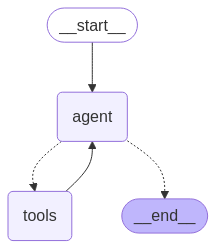

In [114]:
graph = create_react_agent(chat_model, tools=tools, debug=True)

graph

Testing the agent

In [115]:
inputs = {
    "messages": [
        (
            "user", "I have 833 USD and my sister has 38 USD. How much do we have total in euros?"
        )
    ]
}

# we set the debug flag to True to print tasks and their results
response = graph.invoke(inputs, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'I have 833 USD and my sister has 38 USD. How much do we have '
               'total in euros?')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user',
  'I have 833 USD and my sister has 38 USD. How much do we have total in '
  'euros?')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='I have 833 USD and my sister has 38 USD. How much do we have total in euros?', additional_kwargs={}, response_metadata={}, id='93aba02d-4e1d-4fc4-8e5b-4ff718c41215')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,
 'messages': [HumanMessage(content='I have 833 USD and my sister has 38 USD. How much do we have total in euros?', additional_kwargs={}, response_metadata={}, id='93aba02d-4e1d-4fc4-8e5b-4ff718c41215')],
 'remaining_steps': 24}
[1:writes] Finished step 1 with wr

check if response is a set of messages

In [116]:
response

{'messages': [HumanMessage(content='I have 833 USD and my sister has 38 USD. How much do we have total in euros?', additional_kwargs={}, response_metadata={}, id='93aba02d-4e1d-4fc4-8e5b-4ff718c41215'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '091gqrBZU', 'type': 'function', 'function': {'name': 'add', 'arguments': '{"a": 833, "b": 38}'}}, {'id': 'BfnE6mGYA', 'type': 'function', 'function': {'name': 'get_exchange_rate', 'arguments': '{"currency_from": "USD", "currency_to": "EUR"}'}}]}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 627, 'total_tokens': 688}, 'model_name': 'mistralai/mistral-large', 'system_fingerprint': '', 'finish_reason': 'tool_calls'}, id='chatcmpl-dd1c35b592db0f1cafd6b266d68515f2', tool_calls=[{'name': 'add', 'args': {'a': 833, 'b': 38}, 'id': '091gqrBZU', 'type': 'tool_call'}, {'name': 'get_exchange_rate', 'args': {'currency_from': 'USD', 'currency_to': 'EUR'}, 'id': 'BfnE6mGYA', 'type': 'tool_call'}], usage_m

AllMessage is the final response from the model

In [117]:
response["messages"][-1].content

' The exchange rate from USD to EUR is approximately **0.88028** on 2025-04-17.\n\nSo if you exchange **871 USD**, you would get approximately **767.16 EUR**.'

## Adding a RAG tool to the agent

In [9]:
embed_params = {}

watsonx_embedding = WatsonxEmbeddings(
    model_id="ibm/granite-embedding-278m-multilingual",
    url=WX_API_URL,
    project_id=WX_PROJECT_ID,
    apikey=WX_API_KEY,
    params=embed_params,
)

initializing the vector database

In [10]:
vectordb = Chroma(collection_name="my_collection", persist_directory="my_vector_db", embedding_function=watsonx_embedding)

vectordb.get(limit=1)

{'ids': ['7ba2c445-fb8b-4132-878c-00ad46b8abc4'],
 'embeddings': None,
 'documents': ['[About MadeUpCompany]: \nMadeUpCompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. Headquartered in San Francisco, California, we have a global presence with satellite offices in New York, London, and Tokyo. Our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation.  \nWith a diverse team of experts from various industries—including AI research, cybersecurity, and enterprise software development—we push the boundaries of what’s possible. Our commitment to continuous improvement, security, and customer success has earned us recognition as a leader in the tech space.'],
 'uris': None,
 'data': None,
 'metadatas': [{'Header 1': 'About MadeUpCompany'}],
 'included': [<IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

creating the retriever

In [11]:
retriever_tool = create_retriever_tool(
    vectordb.as_retriever(
        search_type="similarity",
        search_kwargs={
            "k": 3,
        }
    ),
    "retrieve_company_information",
    "Search and return information about MadeUpCompany",
)

tools_for_agent = [get_exchange_rate, retriever_tool]

In [12]:
# Use the vectorstore as a retriever
retriever = vectordb.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": 3,
    }
)

retrieved_documents = retriever.invoke("Do you have a 30-day money-back guarantee?")

see our documents and headers

In [158]:
retrieved_documents

[Document(id='149fdb8a-e5ca-4235-a8db-21e7bed0de84', metadata={'Header 1': 'About MadeUpCompany', 'Header 2': 'Refund and Cancellation Policy'}, page_content="[About MadeUpCompany/Refund and Cancellation Policy]: \nWe stand by the quality of our services and offer a 30-day money-back guarantee on all plans.  \nIf you're not satisfied, you can request a full refund within the first 30 days.\nAfter 30 days, you may cancel your subscription at any time, and we’ll issue a prorated refund based on your remaining subscription period.\nEnterprise contracts include a flexible exit clause, ensuring fair terms for long-term clients.\nUpcoming Features"),
 Document(id='16fbc86f-4c00-45d2-b743-1ced10bc7205', metadata={'Header 1': 'About MadeUpCompany', 'Header 2': 'Pricing', 'Header 3': 'CloudMate Plans'}, page_content='[About MadeUpCompany/Pricing/CloudMate Plans]: \nOur secure and scalable cloud storage service, CloudMate, is available in the following plans:\n- Basic: $9.99/month – 100GB storag

In [13]:
graph = create_react_agent(chat_model, tools=tools_for_agent, debug=True)

In [159]:
response = graph.invoke(
    
    {
        "messages": [
            (
                "user", "What is CloudMate from MadeUpCompany? Keep it short and simple."
            )
        ],
    },
    debug=True,
    
)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'What is CloudMate from MadeUpCompany? Keep it short and '
               'simple.')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user', 'What is CloudMate from MadeUpCompany? Keep it short and simple.')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='What is CloudMate from MadeUpCompany? Keep it short and simple.', additional_kwargs={}, response_metadata={}, id='9f3fb7f0-1cce-49c2-bfe1-1addea55cef3')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,
 'messages': [HumanMessage(content='What is CloudMate from MadeUpCompany? Keep it short and simple.', additional_kwargs={}, response_metadata={}, id='9f3fb7f0-1cce-49c2-bfe1-1addea55cef3')],
 'remaining_steps': 24}
[1:writes] Finished step 1 with writes to 1 channel:
- messages -> [AIMessage(content='', add

check response

In [125]:
response["messages"][-1].content

" MadeUpCompany's CloudMate is a secure and scalable cloud storage solution with plans starting from $9.99/month for 100GB to custom pricing for unlimited storage. It features military-grade encryption, multi-factor authentication, and AI-powered file organization."

In [160]:
response = graph.invoke(
    
    {
        "messages": [
            (
                "user", "What is the price of CloudMate Professional? Find the price first and then convert it to euros."
            )
        ],
    },
    debug=True,
    
)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'What is the price of CloudMate Professional? Find the price '
               'first and then convert it to euros.')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user',
  'What is the price of CloudMate Professional? Find the price first and then '
  'convert it to euros.')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='What is the price of CloudMate Professional? Find the price first and then convert it to euros.', additional_kwargs={}, response_metadata={}, id='8bd076bb-aa97-491b-90ba-57a174651503')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,
 'messages': [HumanMessage(content='What is the price of CloudMate Professional? Find the price first and then convert it to euros.', additional_kwargs={}, response_metadata={}, id='8bd076bb-aa97-491b-90ba

In [129]:
print(response["messages"][-1].content)

 The exchange rate of USD to EUR is 0.88028. So, the price of CloudMate Professional in EUR is 26.368632.


adding a search tool

In [14]:
search_tool = DuckDuckGoSearchResults()

In [15]:
tools_for_agent = [get_exchange_rate, retriever_tool, search_tool]

graph = create_react_agent(chat_model, tools= tools_for_agent, debug=True)

In [16]:
response = graph.invoke(
    {
        "messages": [
            (
                "user", "Compare the price of CloudMate Professional from MadeUpCompany with the price of OneDrive from Microsoft. Find the price first and then convert it to euros, if information is not available use the search tool to access online resources"
            )
        ],
    },
    debug=True,
    
)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'Compare the price of CloudMate Professional from MadeUpCompany '
               'with the price of OneDrive from Microsoft. Find the price '
               'first and then convert it to euros, if information is not '
               'available use the search tool to access online resources')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user',
  'Compare the price of CloudMate Professional from MadeUpCompany with the '
  'price of OneDrive from Microsoft. Find the price first and then convert it '
  'to euros, if information is not available use the search tool to access '
  'online resources')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Compare the price of CloudMate Professional from MadeUpCompany with the price of OneDrive from Microsoft. Find the price first and then con

In [164]:
response["messages"][-1].content

' ### CloudMate Professional vs Microsoft OneDrive Pricing Comparison\n\n| Feature                   | MadeUpCompany/CloudMate Professional                  | Microsoft/OneDrive                 |\n|---------------------------|------------------------------------------------------|-----------------------------------|\n| **Monthly Price**         | $29.99 / month                                       | $6.99 / month                     |\n| **Storage**               | 1TB storage                                          | 1TB storage                       |\n| **Security**              | Enhanced security features                           | Advanced security measures        |\n| **Support**               | Priority customer support                            | Customer support                  |\n| **Price in Euros**        | €26.32 (Converted at the exchange rate of 0.88028)   | €7.00 (Approximate conversion)     |\n\nBased on the information provided, here is a comparison of CloudMate

Here is the response i got when displayed in a readable format; 

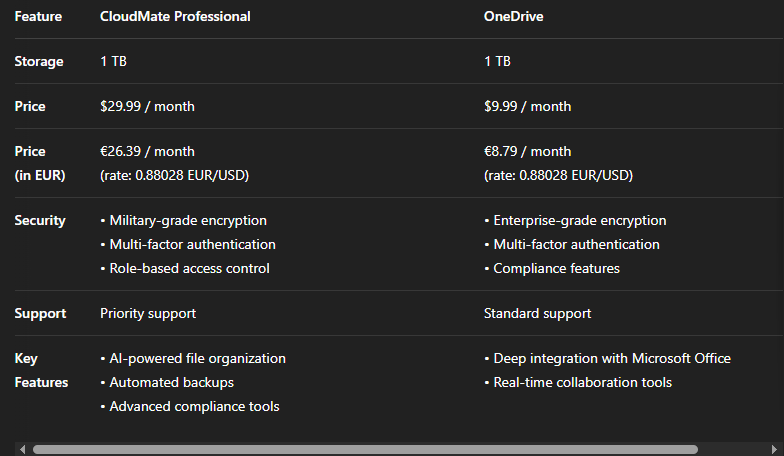

and after some tuning
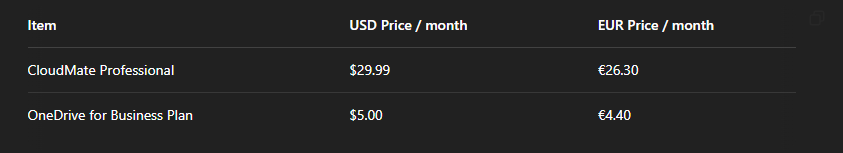


At first i had issues making my Tool agent use all of its available tools, this got solved when the tool was more integrated into the prompt 

## adding and testing new tools


In [ ]:

from langchain.tools.arxiv.tool import ArxivQueryRun

#arxiv_tool = load_tools(["arxiv"]),
arxiv_tool = ArxivQueryRun()

# 4) extend your existing tools list
tools_for_agent = [get_exchange_rate, retriever_tool, search_tool, arxiv_tool,]

graph = create_react_agent(chat_model, tools=tools_for_agent, debug=True)

In [21]:
response = graph.invoke(
    {
        "messages": [
            (
                "user", "please give me the price of madeupcompany's cloudmate professional and the latest arxiv paper on the topic of LLM's. If the information is not available use the search tool to access online resources"
            )
        ],
    },
    debug=True,
    
)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               "please give me the price of madeupcompany's cloudmate "
               "professional and the latest arxiv paper on the topic of LLM's. "
               'If the information is not available use the search tool to '
               'access online resources')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user',
  "please give me the price of madeupcompany's cloudmate professional and the "
  "latest arxiv paper on the topic of LLM's. If the information is not "
  'available use the search tool to access online resources')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content="please give me the price of madeupcompany's cloudmate professional and the latest arxiv paper on the topic of LLM's. If the information is not available use the search tool to access online resources", additional_kwa

In [22]:
response["messages"][-1].content

' Our secure and scalable cloud storage service, CloudMate, is available in the following plans:\n- Basic: $9.99/month – 100GB storage, essential security features\n- Professional: $29.99/month – 1TB storage, enhanced security, priority support\n- Enterprise: Custom pricing – Unlimited storage, advanced compliance tools, dedicated account manager.\n\nHere are three of the latest publications from the provided search:\n\n---\n\n**Title:** Trustworthy and Efficient LLMs Meet Databases\n**Authors:** Kyoungmin Kim, Anastasia Ailamaki\n**Published:** 2024-12-23\n**Summary:** This tutorial explores efforts to make LLMs more trustworthy and efficient, especially in output generation (inference), to reduce hallucinations and meet increased inference demands. It also delves into the synergy between LLMs and databases, highlighting new opportunities and challenges in their intersection.\n\n**Title:** Large Language Models as Software Components: A Taxonomy for LLM-Integrated Applications\n**Auth

As seen above the tool for Arxiv was implemented and tested, in the above promt the Agent does very well at disticting between different tasks and which tools are best suited for each task, delpoys the tool, and outputs the nessesary information.

nessesary tweaks could be lesss max_token_outpu as the responses sometimes became lesss and less relevant as you read through them. 